In [5]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings("ignore")
import pyproj


In [6]:
la_wildfires = pd.read_csv("C:/Users/ryanc/OneDrive/Desktop/Wildfire Project/La WILDFIRES (SINCE 2010).csv")
print(la_wildfires.columns)
print(la_wildfires.shape)

Index(['OBJECTID', 'ABCD Misc', 'ADS Permission State', 'Calculated Acres',
       'Containment Date Time', 'Control Date Time', 'Created By System',
       'Created On Date Time', 'Incident Size', 'Discovery Acres',
       'Dispatch Center ID', 'Estimated Cost To Date', 'Final Acres',
       'Final Fire Report Approved By Title',
       'Final Fire Report Approved By Unit', 'Final Fire Report Approved Date',
       'Fire Behavior General', 'FireCode', 'FireDepartmentID',
       'Fire Discovery Date Time', 'Fire Mgmt Complexity', 'FireOutDateTime',
       'FS Job Code', 'FS Override Code', 'GACC', 'Incident Name',
       'Incident Short Description', 'Incident Type Category',
       'Incident Type Kind', 'Initial Latitude', 'Initial Longitude',
       'Initial Response Date Time', 'Is Fire Cause Investigated',
       'Is FS Assisted', 'Is Reimbursable', 'Is Trespass',
       'Local Incident Identifier', 'Modified On Date Time',
       'Percent Contained', 'City', 'POO County', 'POODisp

The original dataset included detailed fire records collected across multiple agencies. However, many of the columns were metadata fields (e.g. system IDs, timestamps, agency names) or land ownership breakdowns that are not relevant for modeling wildfire risk.

To focus onvariables relevant to wildfire risk, we dropped over 50 columns related to:

System identifiers and timestamps

Fire management agencies and jurisdiction info

Land ownership categories and breakdowns

This reduced the dataset to only those variables relevant to modeling fire duration, acreagefire size, and spatial patterns.

In [7]:
# List of columns to drop
drop_columns = [
    'OBJECTID', 'Created By System', 'Created On Date Time', 'Modified On Date Time',
    'ModifiedBySystem', 'GlobalID', 'UniqueFireIdentifier', 'Final Fire Report Approved By Title',
    'Final Fire Report Approved By Unit', 'Final Fire Report Approved Date',
    'Related Irwin IDs', 'Local Incident Identifier', 'Incident Short Description',
    'Initial Longitude','Initial Latitude',
    'FireDepartmentID', 'FS Job Code', 'FS Override Code', 'Is FS Assisted', 
    'Is Reimbursable', 'Is Trespass', 'Status', 
    'POO Jurisdictional Agency', 'POO Jurisdictional Unit', 
    'POO Jurisdictional Unit Parent Unit', 'POO Landowner Category', 
    'POO Landowner Kind', 'POO Protecting Agency', 'POO Protecting Unit', 
    'POODispatchCenterID', 'Dispatch Center ID',
    'AcresBIA', 'AcresBLM', 'AcresBOR', 'AcresDOD', 'AcresDOE', 'AcresNPS', 
    'AcresUSFS', 'AcresUSFWS', 'AcresForeign', 'AcresTribal', 'AcresCity', 
    'AcresCounty', 'AcresState', 'AcresPrivate', 'AcresANCSA', 'AcresOtherLocal', 
    'AcresOtherFederal'
]

# Drop columns
la_wildfires = la_wildfires.drop(columns=drop_columns, errors='ignore')


In [8]:
# Check available columns in df_cleaned
print("Available columns in df_cleaned:", la_wildfires.columns)

Available columns in df_cleaned: Index(['ABCD Misc', 'ADS Permission State', 'Calculated Acres',
       'Containment Date Time', 'Control Date Time', 'Incident Size',
       'Discovery Acres', 'Estimated Cost To Date', 'Final Acres',
       'Fire Behavior General', 'FireCode', 'Fire Discovery Date Time',
       'Fire Mgmt Complexity', 'FireOutDateTime', 'GACC', 'Incident Name',
       'Incident Type Category', 'Incident Type Kind',
       'Initial Response Date Time', 'Is Fire Cause Investigated',
       'Percent Contained', 'City', 'POO County', 'POO Fips', 'POO State',
       'Predominant Fuel Group', 'Predominant Fuel Model', 'FORID',
       'Initial Response Agencies', 'Fire Cause', 'Fire Cause General',
       'Fire Cause Specific', 'Fire Cause Specific Detail',
       'Fire Cause Age Category', 'Fire Cause Activity Group',
       'IsCauseProhibited', 'Fire Cause Comments', 'Calendar Year', 'x', 'y'],
      dtype='object')


Since this dataset combines fire incident reports from multiple agencies, some variables are reported in some and missing in other reports. To evaluate data quality, we calculated the percentage of missing values in each column to identify features with significant gaps.

In [9]:
# Compute missing values as a percentage
missing_percentage = (la_wildfires.isnull().sum() / len(la_wildfires)) * 100
missing_percentage = missing_percentage[missing_percentage > 0].reset_index()
missing_percentage.columns = ['Column', 'Missing Percentage']

# Display missing values percentage
print(missing_percentage)
print(la_wildfires.shape)

                        Column  Missing Percentage
0                    ABCD Misc           99.035249
1             Calculated Acres           65.565438
2        Containment Date Time           89.646572
3            Control Date Time           98.842298
4                Incident Size           86.973505
5              Discovery Acres          100.000000
6       Estimated Cost To Date          100.000000
7                  Final Acres          100.000000
8        Fire Behavior General          100.000000
9                     FireCode           90.357193
10        Fire Mgmt Complexity           99.891760
11             FireOutDateTime           89.392442
12  Initial Response Date Time           89.505388
13  Is Fire Cause Investigated           97.585769
14           Percent Contained          100.000000
15                        City           99.854111
16                    POO Fips            9.308673
17      Predominant Fuel Group           90.380724
18      Predominant Fuel Model 

To improve model reliability, we removed columns with over 95% missing data and features unrelated to wildfire risk—such as detailed fire causes, fuel types, and response agency info. 

In [ ]:
# List of additional columns to drop due to high missing values and not being related to the project
additional_drop_columns = [
    'ABCD Misc', 'Discovery Acres', 'Estimated Cost To Date', 'Final Acres',
    'Fire Behavior General', 'FireCode', 'Fire Mgmt Complexity',
    'Is Fire Cause Investigated', 'Percent Contained', 'City', 'POO Fips',
    'Predominant Fuel Group', 'Predominant Fuel Model', 'Initial Response Agencies',
    'Fire Cause Specific Detail', 'Fire Cause Age Category', 'Fire Cause Activity Group',
    'Fire Cause Comments'
]

# Drop additional columns
df_cleaned = la_wildfires.drop(columns=additional_drop_columns, errors='ignore')

In [11]:
# Check available columns in df_cleaned
print("Available columns in df_cleaned:", df_cleaned.columns)
print(df_cleaned.shape)

Available columns in df_cleaned: Index(['ADS Permission State', 'Calculated Acres', 'Containment Date Time',
       'Control Date Time', 'Incident Size', 'Fire Discovery Date Time',
       'FireOutDateTime', 'GACC', 'Incident Name', 'Incident Type Category',
       'Incident Type Kind', 'Initial Response Date Time', 'POO County',
       'POO State', 'FORID', 'Fire Cause', 'Fire Cause General',
       'Fire Cause Specific', 'IsCauseProhibited', 'Calendar Year', 'x', 'y'],
      dtype='object')
(21249, 22)


The remaining data contains columns titled x and y. We will convert these to Latitude and Longitude to make it easier to map elevation values.

We then load a downsampled dataset of elevation points, where each row includes only coordinates and an elevation value. To map an elevation value with each fire incident, the cKDTree function from the SciPy library ewas utilized to match each fire's Latitude and Longitude values to the nearest elevation value.

The cKDTree function relies on the concept of a k-d tree, which is a space-partitioning data structure that organizes points in a k-dimensional space. Using latitude and longitude as dimensions, we were able to efficiently assign an elevation value to each fire based on spatial proximity.

In [12]:
# Convert x, y coordinates to Latitude and Longitude (EPSG:3857 -> EPSG:4326)
projected_crs = "EPSG:3857"  # Web Mercator
geographic_crs = "EPSG:4326"  # WGS 84

# Create coordinate transformer
transformer = pyproj.Transformer.from_crs(projected_crs, geographic_crs, always_xy=True)

# Apply transformation
df_cleaned[['Longitude', 'Latitude']] = df_cleaned.apply(
    lambda row: pd.Series(transformer.transform(row['x'], row['y'])), axis=1
)

# Drop old x, y columns
df_cleaned = df_cleaned.drop(columns=['x', 'y'])

# Load elevation dataset
df_elevation = pd.read_csv("C:/Users/ryanc/OneDrive/Desktop/Wildfire Project/elevation_data_downsampled.csv")

# Extract Latitude & Longitude from "coordinates" column in elevation data
df_elevation[['latitude', 'longitude']] = df_elevation['coordinates'].str.extract(r'\(([^,]+),\s*([^)]+)\)').astype(float)

# Drop NaN values
df_elevation = df_elevation.dropna(subset=['latitude', 'longitude'])
df_cleaned = df_cleaned.dropna(subset=['Latitude', 'Longitude'])

# Build KDTree for nearest neighbor search
elevation_tree = cKDTree(df_elevation[['latitude', 'longitude']].values)

# Function to find nearest elevation value
def get_nearest_elevation(lat, lon):
    _, idx = elevation_tree.query([[lat, lon]])  # Find nearest point
    return df_elevation.iloc[idx[0]]['elevation (m)']

# Apply elevation mapping to df_cleaned (not df_elevation!)
df_cleaned['Elevation'] = df_cleaned.apply(lambda row: get_nearest_elevation(row['Latitude'], row['Longitude']), axis=1)
print(df_cleaned.shape)

(21249, 23)


We will drop a few more columns which do not add much information to the wildfire risk model.

In [13]:
# List of columns to drop
columns_to_drop = [
    'ADS Permission State', 'GACC', 'Incident Type Category', 'Incident Type Kind',
    'FORID', 'POO State', 'POO County', 'Fire Cause General', 'Fire Cause Specific', 'IsCauseProhibited'
]

# Drop the columns
df_cleaned = df_cleaned.drop(columns=columns_to_drop, errors='ignore')

# Display remaining columns (optional)
print("Remaining columns:\n", df_cleaned.columns)

print(df_cleaned.isna().sum())
print(df_cleaned.shape)

Remaining columns:
 Index(['Calculated Acres', 'Containment Date Time', 'Control Date Time',
       'Incident Size', 'Fire Discovery Date Time', 'FireOutDateTime',
       'Incident Name', 'Initial Response Date Time', 'Fire Cause',
       'Calendar Year', 'Longitude', 'Latitude', 'Elevation'],
      dtype='object')
Calculated Acres              13932
Containment Date Time         19049
Control Date Time             21003
Incident Size                 18481
Fire Discovery Date Time          0
FireOutDateTime               18995
Incident Name                     0
Initial Response Date Time    19019
Fire Cause                      231
Calendar Year                     0
Longitude                         0
Latitude                          0
Elevation                         0
dtype: int64
(21249, 13)


One of the main factors we want to use to determine wildfire risk is the length of time a fire lasted, which we will call Fire Duration. To do this, we use two date columns with the lowest percentage of missing data: "Fire Discovery Date Time" and "FireOutDateTime". These columns represent the date a fire was first discovered and the date it was completely extinguished, respectively.

While this isn’t a perfect way to calculate fire duration, it is the most accurate measure available in this dataset. We calculate the difference between "FireOutDateTime" and "Fire Discovery Date Time", which gives the exact time down to the minute. We then divide the result by 86,400—the number of seconds in a day—to convert the duration to decimal days.

To ensure accuracy, we only use fire incidents where both of these datetime columns have valid values.

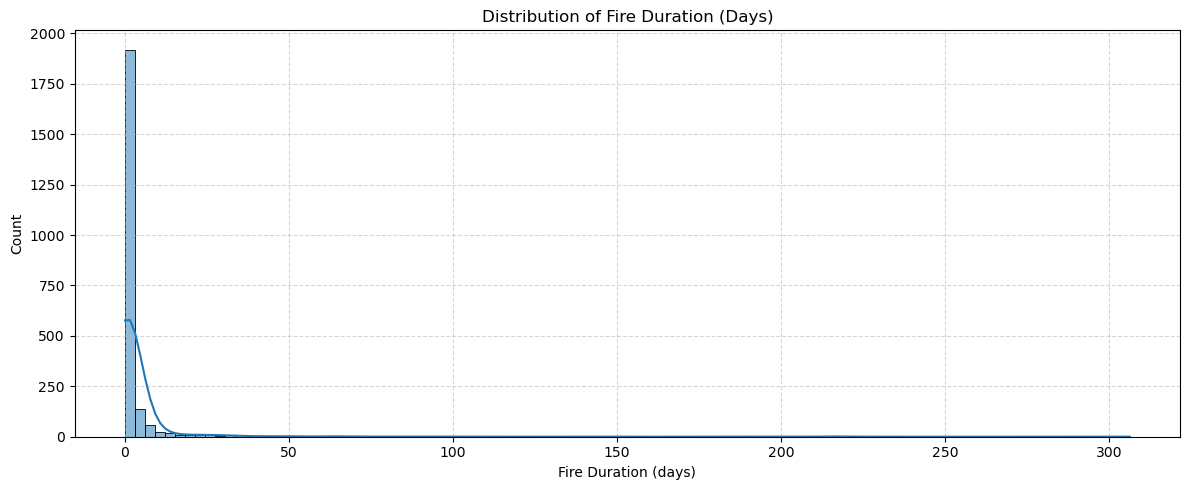

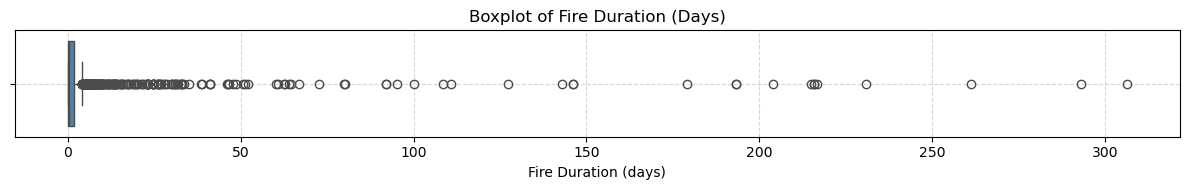


🔹 Column: Calculated Acres
[1.36 1.   0.01 0.99 5.15 0.1  3.16 0.3  2.   0.09]

🔹 Column: Containment Date Time
['6/19/2010 21:00' '6/20/2010 23:15' '7/29/2010 23:59' '7/30/2010 3:20'
 '8/12/2010 23:00' '6/6/2012 20:00' '8/23/2012 21:23' '11/15/2012 4:00'
 '4/21/2013 1:37' '5/28/2014 18:30']

🔹 Column: Control Date Time
['6/22/2022 15:50' '6/23/2022 0:00' '10/15/2022 20:46' '10/14/2022 1:30'
 '8/10/2023 20:58' '8/16/2023 21:06' '8/1/2020 14:52' '9/12/2020 5:19'
 '9/30/2020 13:15' '1/9/2021 20:00']

🔹 Column: Incident Size
[3.0000e-01 1.3918e+04 4.0000e+00 6.0000e-01 1.0000e-01 2.0000e-01
 5.0000e+00 1.2500e+02 1.4000e+00 1.2000e+01]

🔹 Column: Fire Discovery Date Time
<DatetimeArray>
['2010-06-19 20:21:00', '2010-06-20 23:04:00', '2010-07-29 23:24:00',
 '2010-07-30 01:37:00', '2010-08-12 21:35:00', '2012-06-06 09:45:00',
 '2012-08-23 20:52:00', '2012-11-14 20:32:00', '2013-04-20 19:46:00',
 '2014-05-28 18:07:00']
Length: 10, dtype: datetime64[ns]

🔹 Column: FireOutDateTime
<DatetimeAr

In [14]:
# ✅ Convert to datetime (safely handles invalid values)
df_cleaned['Fire Discovery Date Time'] = pd.to_datetime(df_cleaned['Fire Discovery Date Time'], errors='coerce')
df_cleaned['FireOutDateTime'] = pd.to_datetime(df_cleaned['FireOutDateTime'], errors='coerce')

# ✅ Create duration field (in days, rounded to 4 decimals)
df_cleaned['Fire Duration (days)'] = (
    (df_cleaned['FireOutDateTime'] - df_cleaned['Fire Discovery Date Time']).dt.total_seconds() / 86400
).round(4)

# ✅ Split into two versions based on fire duration
df_duration_all = df_cleaned.copy()  # Includes all durations
df_duration_cleaned = df_cleaned[df_cleaned['Fire Duration (days)'] > 0].copy()  # Keeps only valid durations

# ✅ Use only valid durations for plotting
valid_durations = df_duration_cleaned['Fire Duration (days)']

# 🔍 Histogram of valid durations
plt.figure(figsize=(12, 5))
sns.histplot(valid_durations, bins=100, kde=True)
plt.xlabel("Fire Duration (days)")
plt.title("Distribution of Fire Duration (Days)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 🔍 Boxplot of valid durations
plt.figure(figsize=(12, 2))
sns.boxplot(x=valid_durations, color='steelblue')
plt.xlabel("Fire Duration (days)")
plt.title("Boxplot of Fire Duration (Days)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 🔍 Preview unique values per column (up to 10)
for col in df_cleaned.columns:
    print(f"\n🔹 Column: {col}")
    print(df_cleaned[col].dropna().unique()[:10])  # Only non-null unique values


We need to do a little more cleaning before this messy dataset is ready for modeling. There are two columns—"Incident Size" and "Calculated Acres"—which both represent the size of a fire in acres. In many cases, they contain the same value, while in others, one column has a value and the other is missing.

Since "Calculated Acres" has more missing values than "Incident Size", we impute the missing values using the corresponding values from "Incident Size". We create a new column called "Fire_Acres", which combines these into a single, more complete column for fire size. The "Incident Size" and "Calculated Acres" columsn are subsequently dropped since they now contain redundant information.

Additionally, we filter out incidents where the fire size was 0 or 0.01 acres, as these are too small to be considered wildfires in any meaningful sense. These records are not useful for modeling and could introduce noise, so we drop them from the dataset.

In [15]:
# Impute 'Fire_Acres' and REMOVE small fires from both datasets ---

# ✅ 1. Apply to df_duration_cleaned (only rows with valid positive durations)
df_cleaned_filtered = df_duration_cleaned.copy()

# Impute missing 'Calculated Acres' with 'Incident Size'
df_cleaned_filtered['Fire_Acres'] = df_cleaned_filtered['Calculated Acres']
df_cleaned_filtered.loc[
    df_cleaned_filtered['Fire_Acres'].isna(), 'Fire_Acres'
] = df_cleaned_filtered['Incident Size']

# Remove small fires (0 or 0.01 acres)
df_cleaned_filtered = df_cleaned_filtered[
    ~df_cleaned_filtered['Fire_Acres'].isin([0, 0.01])
].copy()

# ✅ 2. Apply to df_duration_all (includes rows with 0 or missing durations)
df_all_filtered = df_duration_all.copy()

# Impute missing 'Calculated Acres' with 'Incident Size'
df_all_filtered['Fire_Acres'] = df_all_filtered['Calculated Acres']
df_all_filtered.loc[
    df_all_filtered['Fire_Acres'].isna(), 'Fire_Acres'
] = df_all_filtered['Incident Size']

# Remove small fires (0 or 0.01 acres)
df_all_filtered = df_all_filtered[
    ~df_all_filtered['Fire_Acres'].isin([0, 0.01])
].copy()

# Drop those size columns now that we have created a new column
df_all_filtered = df_all_filtered.drop(columns= ['Calculated Acres', 'Incident Size'], errors='ignore')
df_cleaned_filtered = df_cleaned_filtered.drop(columns= ['Calculated Acres', 'Incident Size'], errors='ignore')

# Show resulting shapes
print(f"\n🔥 Filtered duration-cleaned dataset: {df_cleaned_filtered.shape}")
print(f"🔥 Filtered duration-all dataset:     {df_all_filtered.shape}")



🔥 Filtered duration-cleaned dataset: (2182, 13)
🔥 Filtered duration-all dataset:     (14641, 13)


The house prices data which this modfel will serve as one of the inputs for only has data between 20187 to 2023, so we will filter out any fire incident which does not have a "Fire Discovery Date Time" in those years.

In [16]:
# Filter out future fires (years 2024 and 2025)

# Ensure datetime format
df_cleaned_filtered['Fire Discovery Date Time'] = pd.to_datetime(df_cleaned_filtered['Fire Discovery Date Time'], errors='coerce')
df_all_filtered['Fire Discovery Date Time'] = pd.to_datetime(df_all_filtered['Fire Discovery Date Time'], errors='coerce')

# Remove rows with year 2024 or 2025
df_cleaned_filtered = df_cleaned_filtered[~df_cleaned_filtered['Fire Discovery Date Time'].dt.year.isin([2024, 2025])]
df_all_filtered = df_all_filtered[~df_all_filtered['Fire Discovery Date Time'].dt.year.isin([2024, 2025])]

# ✅ Show results
print(f"✅ df_cleaned_filtered (no 2024/2025): {df_cleaned_filtered.shape}")
print(f"✅ df_all_filtered (no 2024/2025):     {df_all_filtered.shape}")


✅ df_cleaned_filtered (no 2024/2025): (2085, 13)
✅ df_all_filtered (no 2024/2025):     (12385, 13)


We suspect that the variables "Fire Duration (days)", "Fire_Acres", and "Elevation" do not follow a normal distribution. To verify this, we will examine their distributions using histograms and boxplots.

As shown in the plots, both "Fire Duration (days)" and "Fire_Acres" are right-skewed, which suggests that applying a log transformation during modeling may improve performance and reduce skewness. We also generate a correlation matrix to check for potential multicollinearity between these features.

The results show that while the variables are somewhat correlated, there are no strong linear dependencies that would raise concerns about multicollinearity in the model.

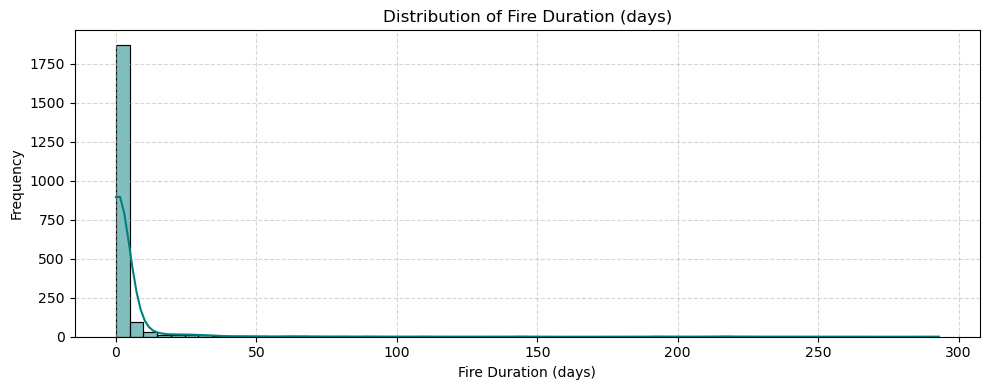

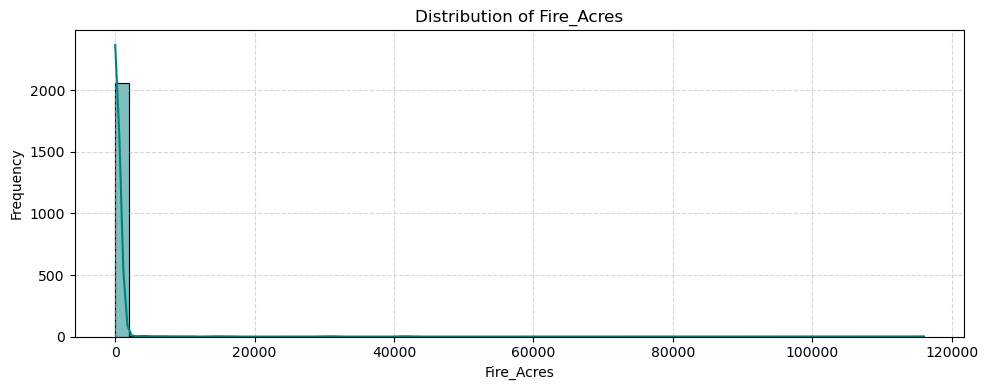

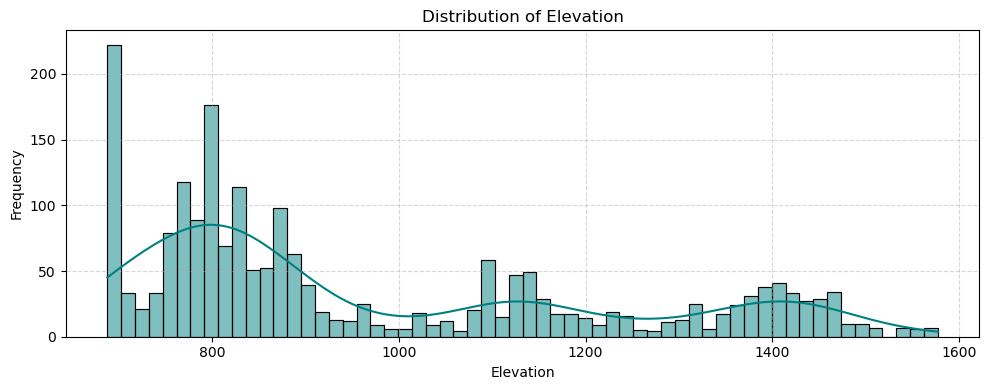

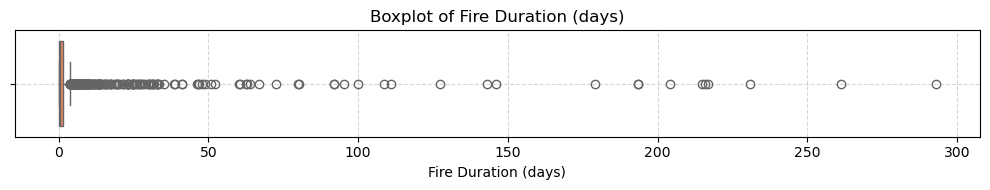

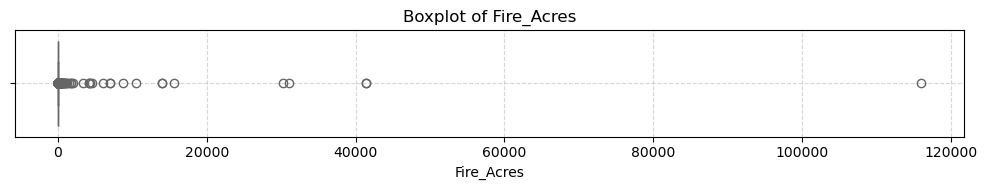

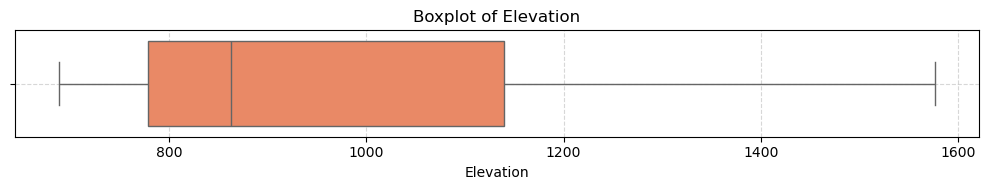

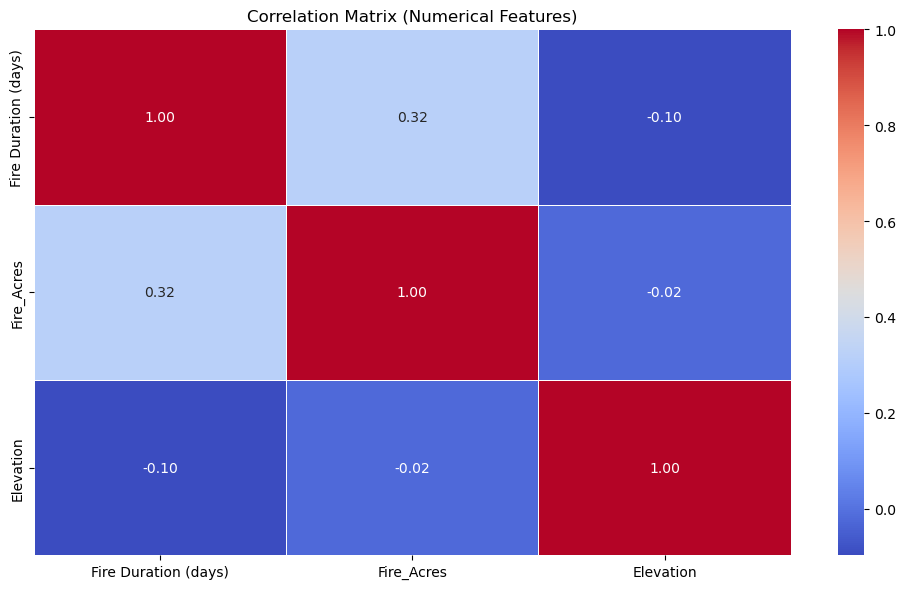

In [17]:
# Choose numeric columns of interest
numeric_cols = [
    'Fire Duration (days)',
    'Fire_Acres',
    'Elevation',
]

# Filter only columns present in the dataset
numeric_cols = [col for col in numeric_cols if col in df_cleaned_filtered.columns]

# 📊 Plot distributions
for col in numeric_cols:
    plt.figure(figsize=(10, 4))
    sns.histplot(df_cleaned_filtered[col].dropna(), bins=60, kde=True, color='teal')
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# 📦 Plot boxplots for outlier detection
for col in numeric_cols:
    plt.figure(figsize=(10, 2))
    sns.boxplot(x=df_cleaned_filtered[col], color='coral')
    plt.title(f"Boxplot of {col}")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# 🔗 Correlation Matrix
correlation_matrix = df_cleaned_filtered[numeric_cols].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix (Numerical Features)")
plt.tight_layout()
plt.show()


In [18]:
print(df_cleaned_filtered.isna().sum())
print(df_all_filtered.isna().sum())

Containment Date Time          335
Control Date Time             1874
Fire Discovery Date Time         0
FireOutDateTime                  0
Incident Name                    0
Initial Response Date Time      31
Fire Cause                      14
Calendar Year                    0
Longitude                        0
Latitude                         0
Elevation                        0
Fire Duration (days)             0
Fire_Acres                       2
dtype: int64
Containment Date Time         10358
Control Date Time             12171
Fire Discovery Date Time          0
FireOutDateTime               10300
Incident Name                     0
Initial Response Date Time    10316
Fire Cause                      157
Calendar Year                     0
Longitude                         0
Latitude                          0
Elevation                         0
Fire Duration (days)          10300
Fire_Acres                     9902
dtype: int64


There are still a large number of missing values in the "Fire Duration" and "Fire Acres" columns, which significantly limit the effectiveness of the model. Over two-thirds of the fire incident records have missing data in at least one of these fields.

We must decide whether to impute the missing values or drop these incomplete records. However, from the distribution plots, it's clear that none of the common imputation methods—including KNN, mean, or median imputation—are able to accurately capture the true distribution of these variables.

As a result, we choose not to impute missing values for either "Fire Duration" or "Fire Acres." Instead, we will exclude fire incidents with missing data in either of these columns to maximize model performance and consistency.


📊 Summary Statistics for Original (NaNs) - df_all_filtered

🔹 Fire Duration (days)
Count: 2085
Missing: 10300
Mean: 3.8143
Median: 0.3125
Std: 18.2431
Min: 0.0007
Max: 292.9681

🔹 Fire_Acres
Count: 2483
Missing: 9902
Mean: 161.2797
Median: 0.1500
Std: 2822.2597
Min: 0.0200
Max: 115998.1700

📊 Summary Statistics for Mean Imputed - df_all_filtered

🔹 Fire Duration (days)
Count: 12385
Missing: 0
Mean: 3.8143
Median: 3.8143
Std: 7.4837
Min: 0.0007
Max: 292.9681

🔹 Fire_Acres
Count: 12385
Missing: 0
Mean: 161.2797
Median: 161.2797
Std: 1263.4772
Min: 0.0200
Max: 115998.1700

📊 Summary Statistics for Median Imputed - df_all_filtered

🔹 Fire Duration (days)
Count: 12385
Missing: 0
Mean: 0.9020
Median: 0.3125
Std: 7.5976
Min: 0.0007
Max: 292.9681

🔹 Fire_Acres
Count: 12385
Missing: 0
Mean: 32.4540
Median: 0.1500
Std: 1265.1231
Min: 0.0200
Max: 115998.1700

📊 Summary Statistics for KNN Imputed - df_all_filtered

🔹 Fire Duration (days)
Count: 12385
Missing: 0
Mean: 3.8414
Median: 3.8143
Std: 7.

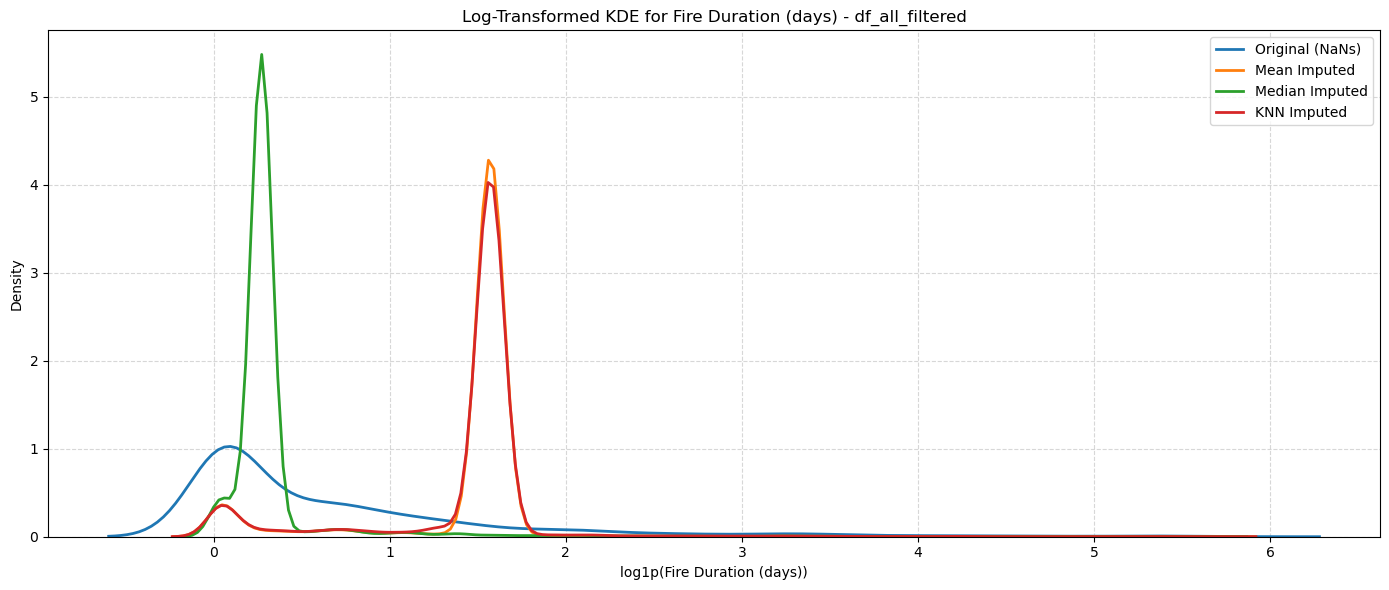

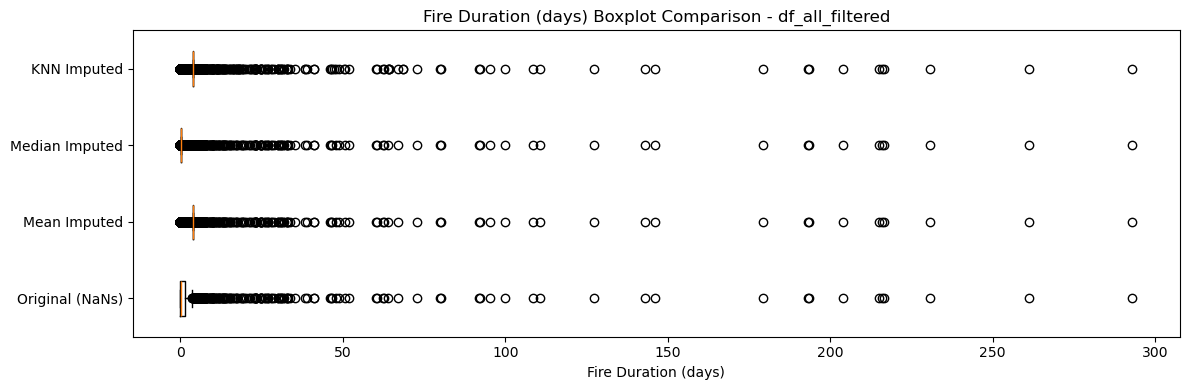

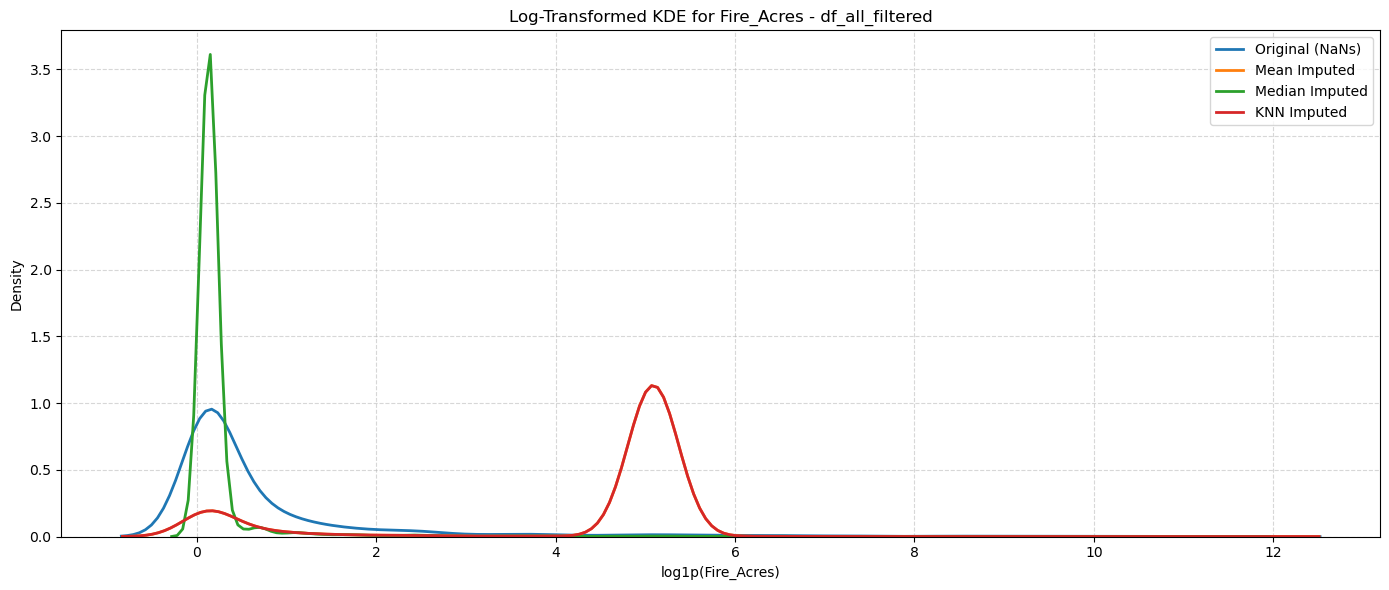

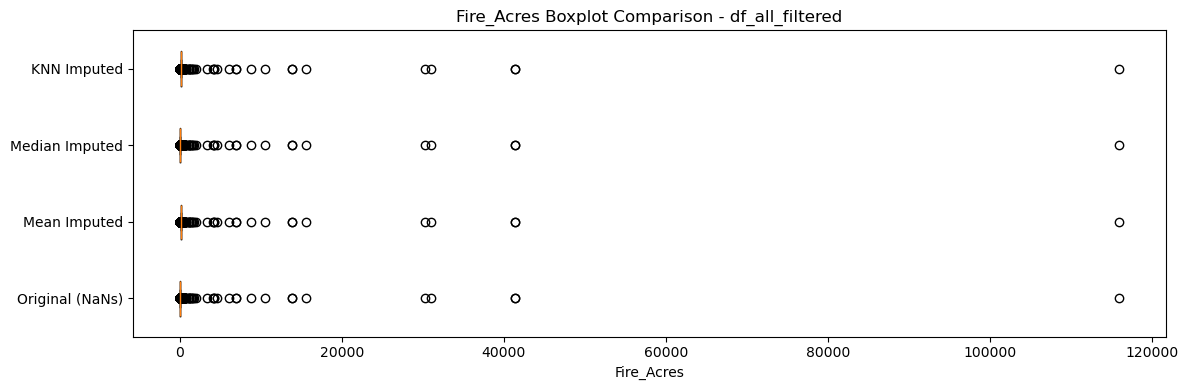


📊 Summary Statistics for Original (NaNs) - df_cleaned_filtered

🔹 Fire Duration (days)
Count: 2085
Missing: 0
Mean: 3.8143
Median: 0.3125
Std: 18.2431
Min: 0.0007
Max: 292.9681

🔹 Fire_Acres
Count: 2083
Missing: 2
Mean: 188.2324
Median: 0.1000
Std: 3080.1877
Min: 0.0200
Max: 115998.1700

📊 Summary Statistics for Mean Imputed - df_cleaned_filtered

🔹 Fire Duration (days)
Count: 2085
Missing: 0
Mean: 3.8143
Median: 0.3125
Std: 18.2431
Min: 0.0007
Max: 292.9681

🔹 Fire_Acres
Count: 2085
Missing: 0
Mean: 188.2324
Median: 0.1000
Std: 3078.7093
Min: 0.0200
Max: 115998.1700

📊 Summary Statistics for Median Imputed - df_cleaned_filtered

🔹 Fire Duration (days)
Count: 2085
Missing: 0
Mean: 3.8143
Median: 0.3125
Std: 18.2431
Min: 0.0007
Max: 292.9681

🔹 Fire_Acres
Count: 2085
Missing: 0
Mean: 188.0519
Median: 0.1000
Std: 3078.7148
Min: 0.0200
Max: 115998.1700

📊 Summary Statistics for KNN Imputed - df_cleaned_filtered

🔹 Fire Duration (days)
Count: 2085
Missing: 0
Mean: 3.8143
Median: 0.3125
St

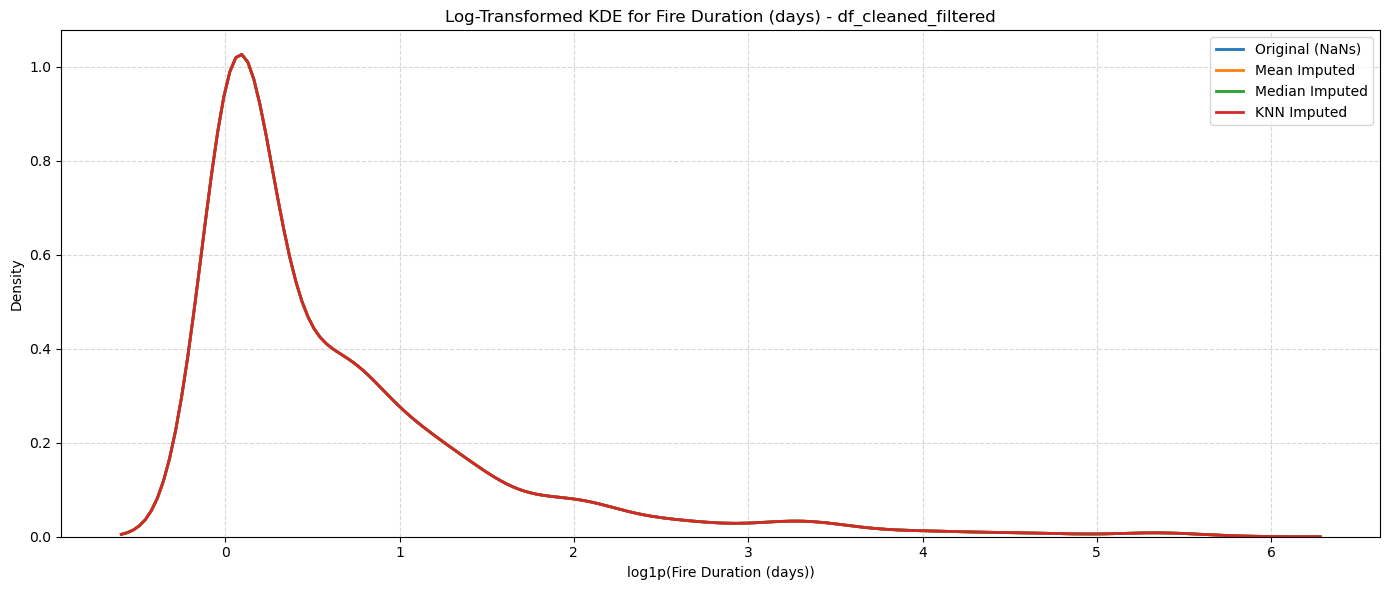

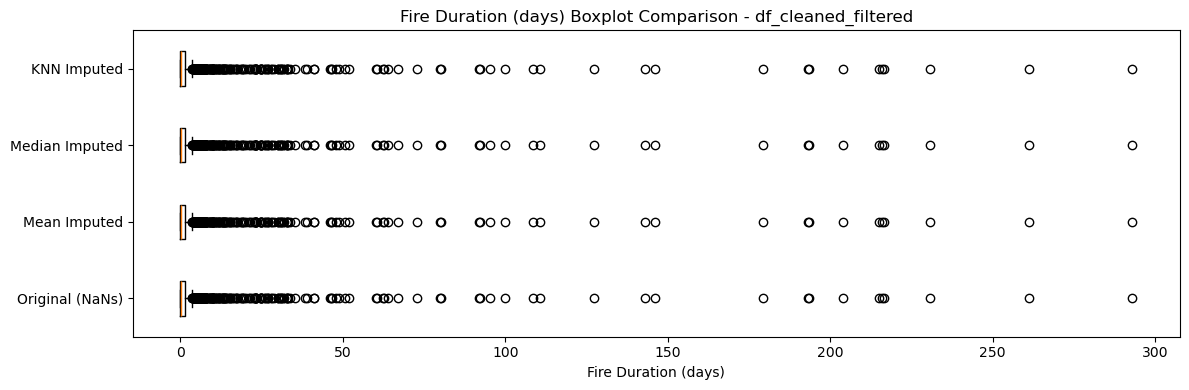

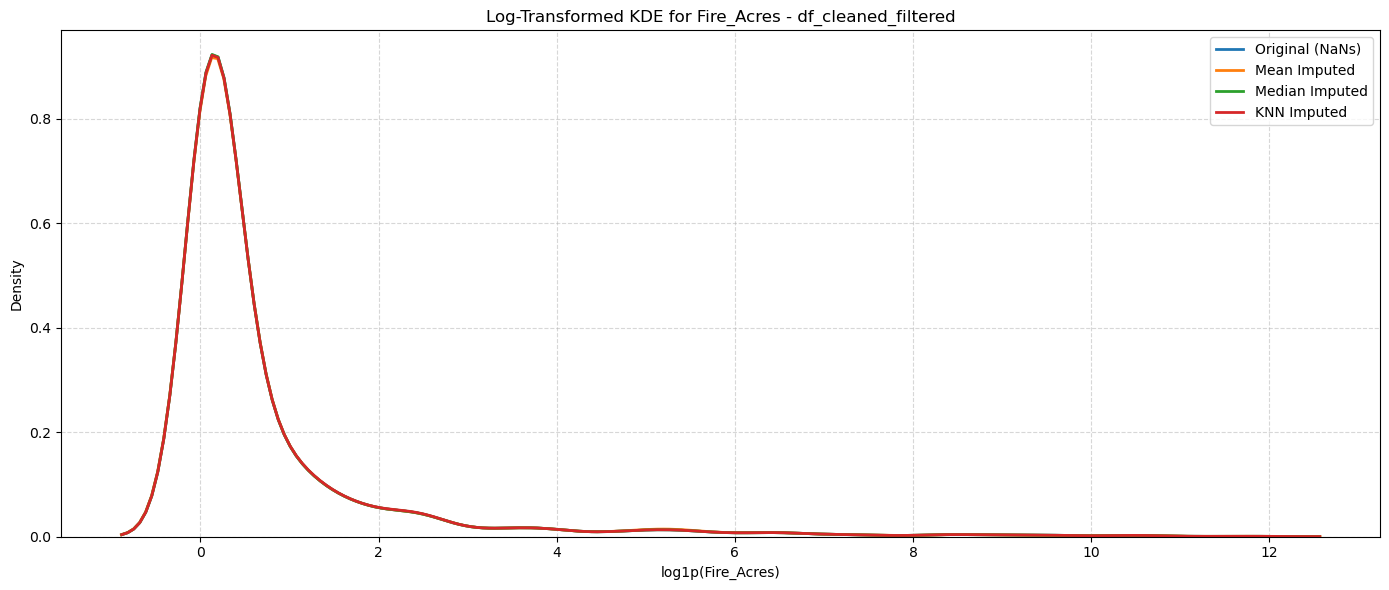

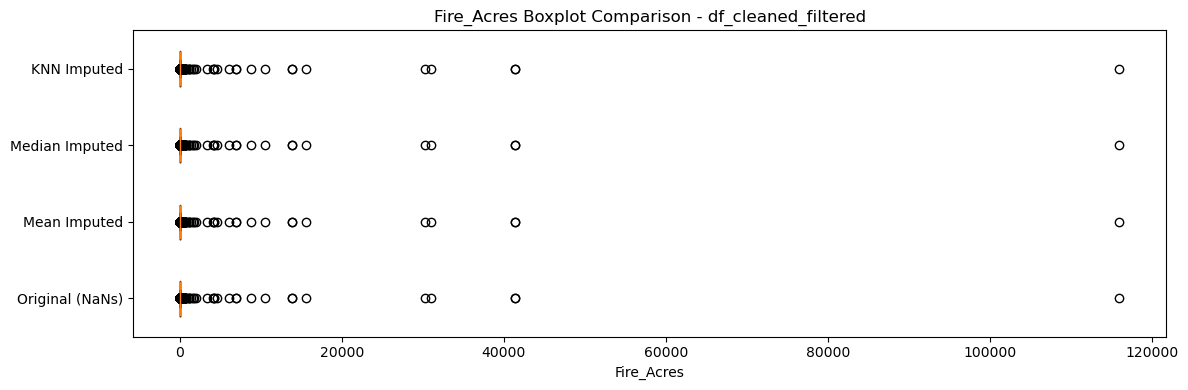

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer

# Columns to evaluate
target_cols = ['Fire Duration (days)', 'Fire_Acres']

# Imputation logic
def apply_imputations(df, method, n_neighbors=5):
    df_imputed = df.copy()
    if method == 'mean':
        for col in target_cols:
            df_imputed[col] = df_imputed[col].fillna(df_imputed[col].mean())
    elif method == 'median':
        for col in target_cols:
            df_imputed[col] = df_imputed[col].fillna(df_imputed[col].median())
    elif method == 'knn':
        imputer = KNNImputer(n_neighbors=n_neighbors)
        df_numeric = df_imputed.copy()
        df_numeric[target_cols] = imputer.fit_transform(df_numeric[target_cols])
        df_imputed[target_cols] = df_numeric[target_cols]
    return df_imputed

# Log-transform (skip zero or negative)
def log_transform(series):
    return np.log1p(series[series > 0])

# Summary stats
def print_summary_stats(df, label):
    print(f"\n📊 Summary Statistics for {label}")
    for col in target_cols:
        series = df[col]
        print(f"\n🔹 {col}")
        print(f"Count: {series.count()}")
        print(f"Missing: {series.isna().sum()}")
        print(f"Mean: {series.mean():.4f}")
        print(f"Median: {series.median():.4f}")
        print(f"Std: {series.std():.4f}")
        print(f"Min: {series.min():.4f}")
        print(f"Max: {series.max():.4f}")

# Combined comparison function
def compare_imputations(df_original, dataset_label):
    imputations = {
        'Original (NaNs)': df_original[target_cols],
        'Mean Imputed': apply_imputations(df_original, 'mean')[target_cols],
        'Median Imputed': apply_imputations(df_original, 'median')[target_cols],
        'KNN Imputed': apply_imputations(df_original, 'knn')[target_cols]
    }

    # 🔎 Print summary stats
    for label, df_version in imputations.items():
        print_summary_stats(df_version, f"{label} - {dataset_label}")

    for col in target_cols:
        # Log KDE Plot
        plt.figure(figsize=(14, 6))
        for label, df_version in imputations.items():
            transformed = log_transform(df_version[col].dropna())
            sns.kdeplot(transformed, label=label, linewidth=2)
        plt.title(f"Log-Transformed KDE for {col} - {dataset_label}")
        plt.xlabel(f"log1p({col})")
        plt.ylabel("Density")
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Boxplot on original scale
        plt.figure(figsize=(12, 4))
        data_to_plot = [df[col].dropna() for df in imputations.values()]
        plt.boxplot(data_to_plot, labels=imputations.keys(), vert=False)
        plt.title(f"{col} Boxplot Comparison - {dataset_label}")
        plt.xlabel(col)
        plt.tight_layout()
        plt.show()

# 🔥 Apply to both datasets
compare_imputations(df_all_filtered, "df_all_filtered")
compare_imputations(df_cleaned_filtered, "df_cleaned_filtered")


Imputing those two predictors would be making too broad of an assumption about 5/6 of the fires. Because of this and other reasons stated above, we drop those observations with missing data in either "Fire Duration" or "Fire Acres." This removes over 80% of the data, but will ensure that our model can more accurately model fire risk with more complete data. The original data source is still in the process of compiling records from multiple sources, so hopefully there will not be this issue with incomplete data in the future. We went from over 12,000 fire incidents to only 2083.

In [21]:
# Lets drop all rows where either Fire_duration or Fire_Acres has missing data
for df in [df_all_filtered, df_cleaned_filtered]:
    # Step 1: Drop rows where Fire Duration or Fire_Acres is missing
    df.dropna(subset=['Fire Duration (days)', 'Fire_Acres'], inplace=True)

    # Step 2: Drop unnecessary datetime columns
    df.drop(columns=['Control Date Time', 'Initial Response Date Time'], inplace=True, errors='ignore')

# Confirm the shape after cleaning
print("📦 df_all_filtered shape:", df_all_filtered.shape)
print("📦 df_cleaned_filtered shape:", df_cleaned_filtered.shape)

📦 df_all_filtered shape: (2083, 11)
📦 df_cleaned_filtered shape: (2083, 11)


In [22]:
# Define the path to your Desktop Wildfire Project folder
base_path = r"C:\Users\ryanc\OneDrive\Desktop\Wildfire Project"

# Save the files
df_cleaned_filtered.to_csv(os.path.join(base_path, "la_wildfires_filtered.csv"), index=False)
df_all_filtered.to_csv(os.path.join(base_path, "la_wildfires_complete.csv"), index=False)

print("✅ CSVs saved to Desktop > Wildfire Project")

✅ CSVs saved to Desktop > Wildfire Project
